In [32]:
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader, TensorDataset, SubsetRandomSampler
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import tensor
import torch.optim as optim
from torchinfo import summary

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Links

https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37
https://deepnote.com/workspace/ludekcizinsky-8f7f55a7-f3c7-4009-b3b2-b7b07fcdf5a7/project/ml202220-44b4318f-b707-4245-8a54-52edfdffa4de/notebook/dd926b1b8ea94ce79538cc9365bc74b7

### Load Data

In [46]:
# Load the data
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

X_train = data_train[:, :-1]
y_train = data_train[:, -1]

X_test = data_test[:, :-1]
y_test = data_test[:, -1]

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).long()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long) 

# Reshape X_train and X_test for convolutional input (assuming 28x28 images)
X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size

# Create TensorDataset
data_training = TensorDataset(X_train_tensor, y_train_tensor)
data_test = TensorDataset(X_test_tensor, y_test_tensor)

In [47]:
# Split training into training and validation
g_cpu = torch.Generator()
g_cpu.manual_seed(3)
data_train, data_val = torch.utils.data.random_split(data_train, [8000, 2000])

### LeNet modified

In [10]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [44]:
class CNN(nn.Module):
    def __init__(self, activation_fn, drop_out_rate, batch_size, epochs, train_data, val_data, test_data, loss_fn, lr, optimizer, verbose, patience=7, delta=0):

        # Inherit from nn module
        super(CNN, self).__init__()

        # Define activation function
        self.activation_fn = activation_fn

        # Define drop ratio
        self.drop_out_rate = drop_out_rate
        
        # Define neural network architecture
        self.nn = nn.Sequential(
                # C1 6@28x28
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(6),
                self.activation_fn(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                
                # C3: 16@10x10
                nn.Dropout(self.drop_out_rate),
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                self.activation_fn(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                
                # Apply flattening on the output
                nn.Flatten(),
                
                # Dense part
                # L1
                nn.Dropout(self.drop_out_rate),
                nn.Linear(16 * 5 * 5, 120),
                nn.BatchNorm1d(120),
                self.activation_fn(),
                
                # L2
                nn.Dropout(self.drop_out_rate),
                nn.Linear(120, 84),
                nn.BatchNorm1d(84),
                self.activation_fn(),
                
                # L3
                nn.Dropout(self.drop_out_rate),
                nn.Linear(84, 10))

        # Define batch size
        self.batch_size = batch_size

        # Define numper of epochs
        self.epochs = epochs

        # Define datasets
        self.training_data = DataLoader(
            train_data, batch_size=self.batch_size, shuffle=True, num_workers=1)
        self.validation_data = DataLoader(
            val_data, batch_size=self.batch_size, shuffle=True, num_workers=1)
        self.test_data = DataLoader(
            test_data, batch_size=len(test_data), shuffle=True, num_workers=1)

        # Define loss function
        self.loss_fn = loss_fn

        # Define learning rate
        self.lr = lr

        # Define optimizer
        self.optimizer = optimizer(self.parameters(), lr=self.lr)

        # Print status if true
        self.verbose = verbose

        # Define patience and delta for early stopping
        self.patience = patience
        self.delta = delta

        # Save training progress
        self.train_loss_history = []
        self.train_acc_history = []

        self.val_loss_history = []
        self.val_acc_history = []
    
    def forward(self, x):
        logits = self.nn(x)
        return logits
    
    def train_loop(self):
        size = len(self.training_data.dataset)
        num_batches = len(self.validation_data)
        train_loss, correct = 0, 0

        for batch, (X, y) in enumerate(self.training_data):
            self.train() # Specify that model is training to enable batchnorm and dropout

            # Compute prediction and loss
            pred = self.forward(X)
            loss = self.loss_fn(pred, y)

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Calculate train loss and accuracy
            train_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            if self.verbose:
                if batch % 20 == 0:
                    loss, current = loss.item(), batch * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_loss /= num_batches
        correct /= size

        # Save it to history
        self.train_acc_history.append(correct)
        self.train_loss_history.append(train_loss)

    def val_loop(self):
        self.eval() # Specify that model is not training to disable batchnorm and dropout
        
        size = len(self.validation_data.dataset)
        num_batches = len(self.validation_data)
        val_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in self.validation_data:

                pred = self.forward(X)

                # Calculate validation loss and accuracy
                val_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        val_loss /= num_batches
        correct /= size

        if self.verbose:
            print(
                f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

        # Save it to history
        self.val_acc_history.append(correct)
        self.val_loss_history.append(val_loss)

    def fit(self):

        early_stopping = EarlyStopping(patience=self.patience, verbose=self.verbose, delta=self.delta)
        
        for t in range(self.epochs):
            if self.verbose:
                print(f"Epoch {t+1}\n-------------------------------")
            
            self.train_loop()
            self.val_loop()

            # Early stopping
            early_stopping(self.val_loss_history[-1], self)

            if early_stopping.early_stop:
                print('Early stopping.')
                break

        print("Done!")

    def predict(self, x):
        logits = self.forward(x)
        softmax = nn.Softmax(dim=1)
        
        return  softmax(logits).argmax(1) #torch.max(logits,1)[1] 

    def test(self):
        # Get data
        X, y = next(iter(self.test_data))

        # Predict values
        y_hat = self.predict(X)

        print("Accuracy score for test data")
        print("-"*60)
        print(f"Acc: {accuracy_score(y, y_hat)*100} %")
        print()
        print("Confusion matrix for test data")
        print("-"*60)
        print(confusion_matrix(y, y_hat))

#### Parameters
**Loss function**<br>
We choose to use cross entropy since we want a categorical output.

**Optimizer**
The optimizer algorithm changes the weights depending on the loss function gradient. We take Adam since it's better than SGD.

**Activation function**
Sigmoid and Softmax.

**Drop out rate**

**Batch_size**

**Epochs**
We use early stopping.

**Learning rate**

In [30]:
# Initialize model
model = CNN(activation_fn=nn.Sigmoid,
         drop_out_rate=0.01,
         batch_size=128, 
         epochs=100, 
         train_data=data_train, 
         val_data=data_val, 
         test_data=data_test, 
         loss_fn=nn.CrossEntropyLoss(), 
         lr=0.001, 
         optimizer=torch.optim.Adam, 
         verbose=True, 
         patience=10, 
         delta=0)

In [31]:
model.fit()

Epoch 1
-------------------------------
loss: 2.402373  [    0/ 8000]
loss: 1.340760  [ 2000/ 8000]
loss: 1.041183  [ 4000/ 8000]
loss: 0.910186  [ 6000/ 8000]
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.799125 

Validation loss decreased (inf --> 0.799125).  Saving model ...
Epoch 2
-------------------------------
loss: 0.857138  [    0/ 8000]
loss: 0.755354  [ 2000/ 8000]
loss: 0.682480  [ 4000/ 8000]
loss: 0.650021  [ 6000/ 8000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.593671 

Validation loss decreased (0.799125 --> 0.593671).  Saving model ...
Epoch 3
-------------------------------
loss: 0.603459  [    0/ 8000]
loss: 0.522484  [ 2000/ 8000]
loss: 0.598482  [ 4000/ 8000]
loss: 0.449836  [ 6000/ 8000]
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.516954 

Validation loss decreased (0.593671 --> 0.516954).  Saving model ...
Epoch 4
-------------------------------
loss: 0.557931  [    0/ 8000]
loss: 0.503548  [ 2000/ 8000]
loss: 0.617813  [ 4000/ 8000]
loss: 0.587528  [ 6000/ 8000]
Te

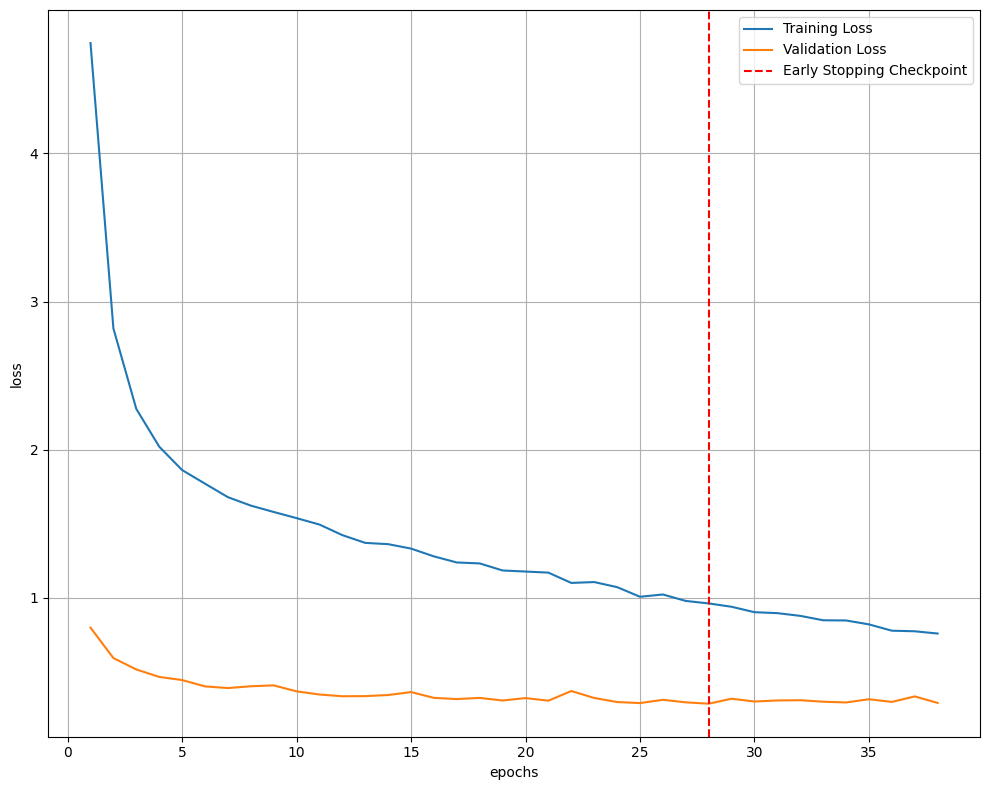

In [33]:
train_loss = model.train_loss_history
valid_loss = model.val_loss_history

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

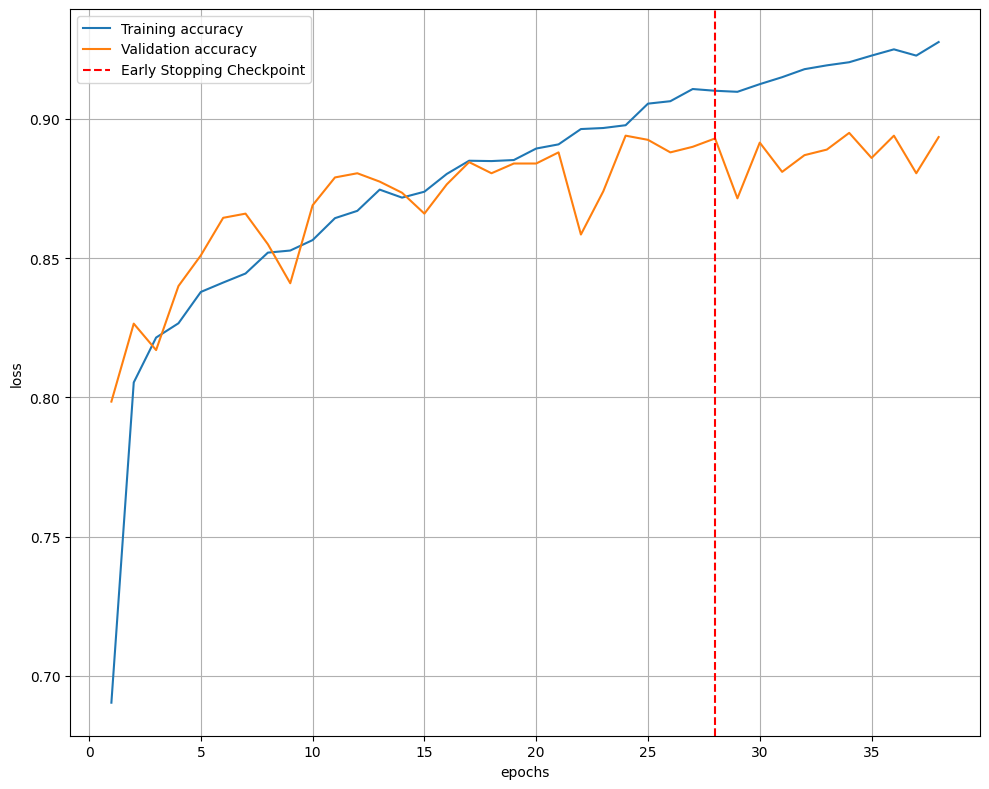

In [34]:
train_acc = model.train_acc_history
valid_acc = model.val_acc_history

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training accuracy')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation accuracy')

# find position of lowest validation loss
#minposs = valid_acc.index(min(valid_acc))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [35]:
model.test()

Accuracy score for test data
------------------------------------------------------------
Acc: 87.1 %

Confusion matrix for test data
------------------------------------------------------------
[[831   0  17  11 141]
 [  2 980   3  13   2]
 [ 14   4 896   9  77]
 [ 33  12   8 906  41]
 [120   3 107  28 742]]


### Cross validation

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, make_scorer

In [73]:
def cross_validate(clfs, X, y):
    accuracy_scores, recall_scores, precision_scores, roc_auc_scores  = [], [], [], []

    for clf in clfs.values():
        accuracy, recall, precision, roc_auc = 0, 0, 0, 0

        num_folds = 5
        skf = StratifiedKFold(num_folds, random_state=0, shuffle=True)

        for fold, (train_idx, val_idx) in enumerate(skf.split(X,y)):
            
            clf.fit(X[train_idx], y_train[train_idx])
            y_hat = clf.predict(X[val_idx])
            y_hat_proba = clf.predict_proba(X[val_idx])
            y_true = y[val_idx]

            accuracy += accuracy_score(y_true, y_hat)
            recall += recall_score(y_true, y_hat, average = 'macro')
            precision += precision_score(y_true, y_hat, average = 'macro')
            roc_auc += roc_auc_score(y_true, y_hat_proba, average = 'macro', multi_class = 'ovr')

        # Average scores
        accuracy /= num_folds
        recall /= num_folds
        precision /= num_folds
        roc_auc /= num_folds

        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        roc_auc_scores.append(roc_auc)

    test_scores = pd.DataFrame({'clf_name': clfs.keys(), 'Accuracy': accuracy_scores, 'Recall': recall_scores, 'Precision': precision_scores, 'Roc_auc': roc_auc_scores})
    return test_scores

In [50]:
history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc': []}

num_folds = 5
learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:
    print(f'Training model with learning rate: {lr}')

    train_loss, val_loss, train_acc, val_acc = 0,0,0,0

    for fold in range(num_folds):
        print(f'Fold {fold}------------------------------')
        data_train, data_val = torch.utils.data.random_split(data_training, [8000, 2000])

        model = CNN(activation_fn=nn.Sigmoid,
            drop_out_rate=0.01,
            batch_size=128, 
            epochs=100, 
            train_data=data_train, 
            val_data=data_val, 
            test_data=data_test, 
            loss_fn=nn.CrossEntropyLoss(), 
            lr=lr, 
            optimizer=torch.optim.Adam, 
            verbose=False, 
            patience=10, 
            delta=0)
    
        model.fit()

        train_loss += model.train_loss_history[-1]
        val_loss += model.val_loss_history[-1]
        train_acc += model.train_acc_history[-1]
        val_acc += model.val_acc_history[-1]

    train_loss /= num_folds
    val_loss /= num_folds
    train_acc /= num_folds
    val_acc /= num_folds

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)


Training model with learning rate: 0.01
Fold 0------------------------------
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Early stopping.
Done!
Fold 1------------------------------
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 

KeyboardInterrupt: 

### Summary

In [31]:
summary(model=model, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNN (CNN)                                [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (nn)                        [1, 1, 28, 28]       [1, 10]              --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─BatchNorm2d (1)                   [1, 6, 28, 28]       [1, 6, 28, 28]       12                   True
│    └─Tanh (2)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (3)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Dropout (4)                       [1, 6, 14, 14]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (5)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─BatchNorm2d (

Idea for variation
- different number of epochs
- different drop out rates
- Implement other neural network structures? ALexNet, ResNet

filter size, stride, padding, pooling type, lr

Batch normalization?

Accuracy, F1 (1 per class), confusion matrix 